In [1]:
import sys
sys.path.append('/media/xreco/jianxun/xGCN')

In [2]:
from utils import io
from utils.utils import ensure_dir

/anaconda/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import torch
import os.path as osp
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [55]:
dataset = 'livejournal'

In [56]:
_node_groups = io.load_pickle('/media/xreco/DEV/xiran/data/social_and_user_item/model_outputs/gnn_'+dataset+'/partition/metis100/node_groups.pkl')

In [57]:
np.random.seed(2022)
for group in _node_groups:
    np.random.shuffle(group)

In [58]:
num_select_groups = 8
all_group_id = np.arange(len(_node_groups))
np.random.shuffle(all_group_id)
select_groups = all_group_id[:num_select_groups]
_node_groups = [_node_groups[i] for i in select_groups]

In [59]:
num_sample_per_group = 500
node_groups = []
_nid = 0
local_idx = []
for group in _node_groups:
    group_nids = group[:num_sample_per_group]
    node_groups.append(group_nids)
    local_idx.append(np.arange(_nid, _nid + len(group_nids)))
    _nid += len(group_nids)

In [66]:
model = 'node2vec'

cache_root = osp.join('data', dataset, model)
ensure_dir(cache_root)
cache_file = osp.join(cache_root, 'tsne_emb.pkl')

if osp.exists(cache_file):
    X = io.load_pickle(cache_file)
else:
    emb_file = '/media/xreco/DEV/xiran/data/social_and_user_item/best_embeddings/'+dataset+'/'+model+'/out_emb_table.pt'
    out_emb_table = torch.load(emb_file,
                            map_location='cpu').detach().numpy()

    embs = []
    for nids in node_groups:
        embs.append(out_emb_table[nids])
    embs = np.concatenate(embs)
    embs.shape

    X = TSNE(n_components=2, perplexity=100.0).fit_transform(embs)
    io.save_pickle(cache_file, X)

In [67]:
# colors = [
#     'red', 
#     'lawngreen', 
#     'orangered',
#     'deepskyblue', 
#     'mediumspringgreen',
#     'cyan', 
#     'darkorchid', 
#     'deeppink', 
#     'yellow',
# ]
colors = [
    '#EB5353',
    '#F9D923',
    '#36AE7C',
    '#187498',
    '#37E2D5',
    '#C70A80',
    '#B4FF9F',
    # '#6BCB77',
    '#F47340'
]

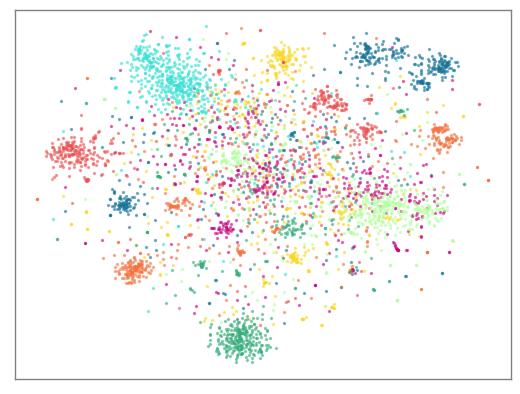

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1)

for i in range(len(local_idx)):
    idx = local_idx[i]
    x = X[idx]
    color = colors[i]
    ax.scatter(x[:, 0], x[:, 1], color=color, s=2, alpha=0.5)

title = 'tsne-' + dataset + '-' + model
# ax.set_title(title)

# plt.axis('off')
plt.xticks([])
plt.yticks([])
ax = plt.gca()
color = 'gray'
width = 1
for spine in ['top','right','bottom','left']:
    ax.spines[spine].set_color(color)
    ax.spines[spine].set_linewidth(width)

results_root = '/media/xreco/DEV/xiran/data/social_and_user_item/model_outputs/figure-www23'
fig.savefig(osp.join(results_root, title + '.pdf'), dpi=300, bbox_inches='tight')
plt.show()